# Investigating different payload size in terms of wallclock time

For this experiment, a total of 5 workflows have been injected into testbed, modifying their `RequestNumEvents` and `EventsPerJob` parameters, such that they remain constant in terms of grid jobs created (each created between 57 and 63 jobs).
1) amaltaro_SC_EL8_Agent237_Val_241204_222944_8239 with 200 EpJ
2) amaltaro_SC_EL8_Agent237_Val_241204_223031_3177 with 400 EpJ
3) amaltaro_SC_EL8_Agent237_Val_241204_223118_4550 with 600 EpJ
4) amaltaro_SC_EL8_Agent237_Val_241204_223149_9917 with 800 EpJ
5) amaltaro_SC_EL8_Agent237_Val_241204_223217_1163 with 1000 EpJ

In [54]:
import os
import sys
import json
import statistics
import pandas as pd
from pprint import pprint, pformat
from tabulate import tabulate

## Copy data from WMArchive/Opensearch to local node

This data has been retrieved from AFS with the following command:
```
amaltaro@lxplus987:~/opensearch $ /cvmfs/cms.cern.ch/cmsmon/monit -token $GRAFANA_TOKEN -query=query5.json -dbname=WMArchive-test | jq  > wmarchive_out.json
```

In [4]:
# now load the wmarchive_out.json file
with open('wmarchive_out.json', 'r') as f:
    wma_data = json.load(f)

## Inspect the data and make it more readable

In [30]:
wma_data.keys()

dict_keys(['responses', 'took'])

In [31]:
wma_data['responses'][0].keys()


dict_keys(['_shards', 'hits', 'status', 'timed_out', 'took'])

In [33]:
print(f"Shards:    {wma_data['responses'][0]['_shards']}")
print(f"Status:    {wma_data['responses'][0]['status']}")
print(f"Timed out: {wma_data['responses'][0]['timed_out']}")
print(f"Took:      {wma_data['responses'][0]['took']}")

Shards:    {'failed': 0, 'skipped': 3078, 'successful': 3216, 'total': 3216}
Status:    200
Timed out: False
Took:      6244


In [36]:
print(f"Keys:      {wma_data['responses'][0]['hits'].keys()}")
print(f"Max score: {wma_data['responses'][0]['hits']['max_score']}")
print(f"Total:     {wma_data['responses'][0]['hits']['total']}")
print(f"Hits:      {len(wma_data['responses'][0]['hits']['hits'])}")

Keys:      dict_keys(['hits', 'max_score', 'total'])
Max score: 0
Total:     {'relation': 'eq', 'value': 289}
Hits:      289


In [29]:
#pprint(wma_data['responses'][0]['hits']['hits'][0])
pprint(wma_data['responses'][0]['hits']['hits'][0]['_source']['data'])


{'Campaign': '',
 'EOSLogURL': '',
 'LFNArray': ['/store/unmerged/logs/prod/2024/12/4/amaltaro_SC_EL8_Agent237_Val_241204_222944_8239/GenSimFull/0000/0/0ced8ea8-624f-4efa-8193-294c54ddb146-49-0-logArchive.tar.gz',
              '/store/unmerged/CMSSW_12_4_0_pre2/RelValWToLNu_14TeV/GEN-SIM/GenSimFull_SC_EL8_Agent237_Val_200EpJ-v11/00000/1477f0b6-1f64-4fc1-bee9-47da765ece61.root'],
 'LFNArrayRef': ['inputLFNs', 'outputLFNs', 'skippedFiles', 'fallbackFiles'],
 'PrepID': 'TEST-CMSSW_12_4_0_pre2_Step1',
 'WMTiming': {'WMJobEnd': 1733355761,
              'WMJobStart': 1733354650,
              'WMTotalWallClockTime': 1111},
 'WorkerNodeInfo': {'HostName': 'b9p23p0952.cern.ch',
                    'JobFeatures': {},
                    'MachineFeatures': {}},
 'fallbackFiles': [],
 'meta_data': {'agent_ver': '2.3.7.1',
               'fwjr_id': '250-0',
               'host': 'vocms0193.cern.ch',
               'jobstate': 'success',
               'jobtype': 'Production',
               'ts

In [38]:
### Create a dictionary of workflows and their records in a list, e.g.:
# {'wf_1': [record_1, record_2, ...], 'wf_2': [record_1, record_2, ...], ...}
wflows = ['amaltaro_SC_EL8_Agent237_Val_241204_222944_8239',
          'amaltaro_SC_EL8_Agent237_Val_241204_223031_3177',
          'amaltaro_SC_EL8_Agent237_Val_241204_223118_4550',
          'amaltaro_SC_EL8_Agent237_Val_241204_223149_9917',
          'amaltaro_SC_EL8_Agent237_Val_241204_223217_1163']

wflow_data = {}
# now iterate through each hit and extract the data
for record in wma_data['responses'][0]['hits']['hits']:
    for wflow in wflows:
        if wflow in record['_source']['data']['task']:
            wflow_data.setdefault(wflow, [])
            wflow_data[wflow].append(record['_source']['data'])

In [43]:
for wflow, records in wflow_data.items():
    print(f"{wflow}: {len(records)}")
total_records = sum(len(records) for records in wflow_data.values())
print(f"Total records: {total_records}")

amaltaro_SC_EL8_Agent237_Val_241204_222944_8239: 54
amaltaro_SC_EL8_Agent237_Val_241204_223031_3177: 55
amaltaro_SC_EL8_Agent237_Val_241204_223118_4550: 58
amaltaro_SC_EL8_Agent237_Val_241204_223217_1163: 61
amaltaro_SC_EL8_Agent237_Val_241204_223149_9917: 61
Total records: 289


In [44]:
# dump the content of wflow_data to a json file
with open('wmarchive_out_clean.json', 'w') as f:
    json.dump(wflow_data, f)

## Explore relevant metrics and generate a CVS file

Apparently, these are important metrics to keep track of:

**High level metrics:**
- wallclocktime in seconds: `['WMTiming']['WMTotalWallClockTime']`
- worker node info:         `['WorkerNodeInfo']['HostName']`
- job type:                 `['meta_data']['jobtype']`
- job state:                `['meta_data']['jobstate']`

**Step level metrics:**
- WMCMSSWSubprocess step name/type:            `['steps'][0]['name']`
- WMCMSSWSubprocess wallclocktime in seconds:  `['steps'][0]['WMCMSSWSubprocess']['wallClockTime']`
- CMSSW step number of events in the output:   `['steps'][0]['output'][0]['events']`
- CMSSW step size in bytes of the output file: `['steps'][0]['output'][0]['size']`
- CMSSW step output location:                  `['steps'][0]['output'][0]['location']`
- CMSSW performance peak RSS memory:           `['steps'][0]['performance']['cmssw']['ApplicationMemory']['PeakValueRss']`
- CMSSW performance CPU model:                 `['steps'][0]['performance']['cmssw']['SystemCPU']['CPUModels']`
- CMSSW performance CPU frequency:             `['steps'][0]['performance']['cmssw']['SystemCPU']['averageCoreSpeed']`
- CMSSW performance Timing number of cores:    `['steps'][0]['performance']['cmssw']['Timing']['NumberOfThreads']`
- CMSSW performance Timing number of streams:  `['steps'][0]['performance']['cmssw']['Timing']['NumberOfStreams']`
- CMSSW performance Timing total job CPU:      `['steps'][0]['performance']['cmssw']['Timing']['TotalJobCPU']`
- CMSSW performance Timing total job time:     `['steps'][0]['performance']['cmssw']['Timing']['TotalJobTime']`
- CMSSW performance Timing event throughput:   `['steps'][0]['performance']['cmssw']['Timing']['EventThroughput']`


In [45]:
# create a panda dataframe with the relevant metrics
header = ['wf_name', 'wm_job_wct', 'worker_node', 'job_type', 'job_state', 'step_name',
          'wm_cmssw_wct', 'wm_output_events', 'wm_output_size', 'wm_output_location',
          'cmssw_perf_peakrss', 'cmssw_perf_cpumodel', 'cmssw_perf_cpufrequency',
          'cmssw_perf_threads', 'cmssw_perf_streams',
          'cmssw_perf_totaljobcpu', 'cmssw_perf_totaljobtime', 'cmssw_perf_eventthroughput']

In [53]:
# Only process data for steps called cmsRun1
all_data = []
for wflow, records in wflow_data.items():
    for record in records:
        for step in record['steps']:
            step_name = step['name']
            if step_name != 'cmsRun1':
                #print(f"Skipping job record for workflow {wflow} and step {step_name}")
                continue

            rec_summary = []
            rec_summary.append(wflow)
            rec_summary.append(record['WMTiming']['WMTotalWallClockTime'])
            rec_summary.append(record['WorkerNodeInfo']['HostName'])
            rec_summary.append(record['meta_data']['jobtype'])
            rec_summary.append(record['meta_data']['jobstate'])
            rec_summary.append(step['name'])
            rec_summary.append(step['WMCMSSWSubprocess'].get('wallClockTime', None))
            rec_summary.append(step['output'][0].get('events', None))
            rec_summary.append(step['output'][0].get('size', None))
            rec_summary.append(step['output'][0].get('location', None))
            rec_summary.append(step['performance']['cmssw']['ApplicationMemory']['PeakValueRss'])
            rec_summary.append(step['performance']['cmssw']['SystemCPU']['CPUModels'])
            rec_summary.append(step['performance']['cmssw']['SystemCPU']['averageCoreSpeed'])
            rec_summary.append(step['performance']['cmssw']['Timing']['NumberOfThreads'])
            rec_summary.append(step['performance']['cmssw']['Timing']['NumberOfStreams'])
            rec_summary.append(step['performance']['cmssw']['Timing']['TotalJobCPU'])
            rec_summary.append(step['performance']['cmssw']['Timing']['TotalJobTime'])
            rec_summary.append(step['performance']['cmssw']['Timing']['EventThroughput'])
            all_data.append(rec_summary)

In [55]:
# now load all_data into a pandas dataframe
df = pd.DataFrame(all_data, columns=header)
df.to_csv('wmarchive_out_clean.csv', index=False)

In [56]:
df

,wf_name,wm_job_wct,worker_node,job_type,job_state,step_name,wm_cmssw_wct,wm_output_events,wm_output_size,wm_output_location,cmssw_perf_peakrss,cmssw_perf_cpumodel,cmssw_perf_cpufrequency,cmssw_perf_threads,cmssw_perf_streams,cmssw_perf_totaljobcpu,cmssw_perf_totaljobtime,cmssw_perf_eventthroughput
0,amaltaro_SC_EL8_Agent237_Val_241204_222944_8239,1111,b9p23p0952.cern.ch,Production,success,cmsRun1,1061.077432,200,1.130894e+08,T2_CH_CERN,1431.890,AMD EPYC 7302 16-Core Processor,3170.95,1,2,1889.0100,1055.7000,0.194213
1,amaltaro_SC_EL8_Agent237_Val_241204_222944_8239,878,b9p02p9818.cern.ch,Production,success,cmsRun1,837.219018,200,1.069348e+08,T2_CH_CERN,1445.690,AMD EPYC 7543 32-Core Processor,3081.65,1,2,1501.6700,832.8330,0.245367
2,amaltaro_SC_EL8_Agent237_Val_241204_222944_8239,943,b9p09p1103.cern.ch,Production,success,cmsRun1,896.845809,200,1.167627e+08,T2_CH_CERN,1423.610,AMD EPYC 7543 32-Core Processor,3044.41,1,2,1626.5600,892.4870,0.229625
3,amaltaro_SC_EL8_Agent237_Val_241204_222944_8239,1067,b9p02p0266.cern.ch,Production,success,cmsRun1,1021.115185,200,1.185460e+08,T2_CH_CERN,1437.330,AMD EPYC 7543 32-Core Processor,2992.03,1,2,1848.6200,1016.1900,0.201161
4,amaltaro_SC_EL8_Agent237_Val_241204_222944_8239,1046,b9p02p0266.cern.ch,Production,success,cmsRun1,996.684012,200,1.143635e+08,T2_CH_CERN,1439.220,AMD EPYC 7543 32-Core Processor,3012.49,1,2,1802.7900,991.8560,0.206183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,amaltaro_SC_EL8_Agent237_Val_241204_223149_9917,6817,b9p13p7703.cern.ch,Production,success,cmsRun1,6762.492425,800,4.388964e+08,T2_CH_CERN,1462.320,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,2902.14,1,2,7723.6800,6756.7700,0.118883
280,amaltaro_SC_EL8_Agent237_Val_241204_223149_9917,217,b9p23p0952.cern.ch,Merge,success,cmsRun1,135.332957,4000,2.289594e+09,T2_CH_CERN,656.688,AMD EPYC 7302 16-Core Processor,3130.56,1,1,97.7223,128.8520,37.078000
281,amaltaro_SC_EL8_Agent237_Val_241204_223149_9917,9618,b9p20p8436.cern.ch,Production,success,cmsRun1,9557.688763,800,4.655076e+08,T2_CH_CERN,1455.850,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,2425.30,1,2,9834.9200,9551.5500,0.084011
282,amaltaro_SC_EL8_Agent237_Val_241204_223149_9917,147,b9p06p3387.cern.ch,Merge,success,cmsRun1,94.970554,4000,2.310710e+09,T2_CH_CERN,651.293,AMD EPYC 7543 32-Core Processor,3111.12,1,1,63.8419,90.6928,55.953000


<Axes: xlabel='wm_output_events', ylabel='wallclock time (secs)'>

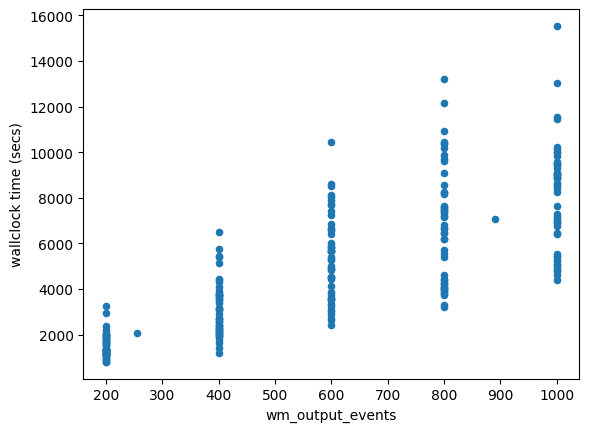

In [60]:
# for job_type == "Production", plot the wallclock time as a function of the number of events
df_prod = df[df['job_type'] == 'Production']
df_prod.plot(x='wm_output_events', y='wm_job_wct', kind='scatter', ylabel='wallclock time (secs)')

In [70]:
# describe the dataframe for each wf_name for job_type == "Production"
# describe only the wm_job_wct
# add the wm_output_events column to the describe
df_prod.groupby('wf_name')[['wm_job_wct', 'wm_output_events']].describe()


wm_job_wct           \
                                                     count     mean   
wf_name                                                               
amaltaro_SC_EL8_Agent237_Val_241204_222944_8239       50.0  1503.82   
amaltaro_SC_EL8_Agent237_Val_241204_223031_3177       50.0  3102.42   
amaltaro_SC_EL8_Agent237_Val_241204_223118_4550       50.0  5322.98   
amaltaro_SC_EL8_Agent237_Val_241204_223149_9917       50.0  6840.52   
amaltaro_SC_EL8_Agent237_Val_241204_223217_1163       50.0  8007.74   

                                                                               \
                                                         std     min      25%   
wf_name                                                                         
amaltaro_SC_EL8_Agent237_Val_241204_222944_8239   505.430578   803.0  1160.75   
amaltaro_SC_EL8_Agent237_Val_241204_223031_3177  1187.300971  1215.0  2206.75   
amaltaro_SC_EL8_Agent237_Val_241204_223118_4550  1904.279343  2059.0  3668.75   
amaltaro_SC_EL8_Agent237_Val_241204_223149_9917  2529.640147  3192.0  4298.25   
amaltaro_SC_EL8_Agent237_Val_241204_223217_1163  2330.576926  4413.0  6429.50   

                                                                           \
                                                    50%      75%      max   
wf_name                                                                     
amaltaro_SC_EL8_Agent237_Val_241204_222944_8239  1360.0  1803.25   3261.0   
amaltaro_SC_EL8_Agent237_Val_241204_223031_3177  2814.5  3743.75   6508.0   
amaltaro_SC_EL8_Agent237_Val_241204_223118_4550  5302.5  6603.00  10431.0   
amaltaro_SC_EL8_Agent237_Val_241204_223149_9917  6754.5  8240.00  13213.0   
amaltaro_SC_EL8_Agent237_Val_241204_223217_1163  8470.5  9416.75  15533.0   

                                                wm_output_events          \
                                                           count    mean   
wf_name                                                                    
amaltaro_SC_EL8_Agent237_Val_241204_222944_8239             50.0  200.00   
amaltaro_SC_EL8_Agent237_Val_241204_223031_3177             50.0  400.00   
amaltaro_SC_EL8_Agent237_Val_241204_223118_4550             50.0  593.12   
amaltaro_SC_EL8_Agent237_Val_241204_223149_9917             50.0  800.00   
amaltaro_SC_EL8_Agent237_Val_241204_223217_1163             50.0  997.82   

                                                                           \
                                                       std    min     25%   
wf_name                                                                     
amaltaro_SC_EL8_Agent237_Val_241204_222944_8239   0.000000  200.0   200.0   
amaltaro_SC_EL8_Agent237_Val_241204_223031_3177   0.000000  400.0   400.0   
amaltaro_SC_EL8_Agent237_Val_241204_223118_4550  48.648947  256.0   600.0   
amaltaro_SC_EL8_Agent237_Val_241204_223149_9917   0.000000  800.0   800.0   
amaltaro_SC_EL8_Agent237_Val_241204_223217_1163  15.414928  891.0  1000.0   

                                                                         
                                                    50%     75%     max  
wf_name                                                                  
amaltaro_SC_EL8_Agent237_Val_241204_222944_8239   200.0   200.0   200.0  
amaltaro_SC_EL8_Agent237_Val_241204_223031_3177   400.0   400.0   400.0  
amaltaro_SC_EL8_Agent237_Val_241204_223118_4550   600.0   600.0   600.0  
amaltaro_SC_EL8_Agent237_Val_241204_223149_9917   800.0   800.0   800.0  
amaltaro_SC_EL8_Agent237_Val_241204_223217_1163  1000.0  1000.0  1000.0

In [81]:
# sum the total wm_job_wct and wm_output_events for each wf_name
df_prod.groupby('wf_name')[['wm_job_wct', 'wm_output_events']].sum()

,wm_job_wct,wm_output_events
wf_name,,
amaltaro_SC_EL8_Agent237_Val_241204_222944_8239,75191,10000
amaltaro_SC_EL8_Agent237_Val_241204_223031_3177,155121,20000
amaltaro_SC_EL8_Agent237_Val_241204_223118_4550,266149,29656
amaltaro_SC_EL8_Agent237_Val_241204_223149_9917,342026,40000
amaltaro_SC_EL8_Agent237_Val_241204_223217_1163,400387,49891


In [71]:
# for each wf_name, count the number of records for each job_state
df_prod.groupby('wf_name')['job_state'].value_counts()


wf_name                                          job_state
amaltaro_SC_EL8_Agent237_Val_241204_222944_8239  success      50
amaltaro_SC_EL8_Agent237_Val_241204_223031_3177  success      50
amaltaro_SC_EL8_Agent237_Val_241204_223118_4550  success      49
                                                 jobfailed     1
amaltaro_SC_EL8_Agent237_Val_241204_223149_9917  success      50
amaltaro_SC_EL8_Agent237_Val_241204_223217_1163  success      49
                                                 jobfailed     1
Name: count, dtype: int64

## Fetching information from condor schedd

Log to the relevant node and run a command similar to:
```
condor_history -since "JobStartDate <= $(($(date +%s) - 35*24*60*60))" -const 'CMS_JobType == "Production"' -af:h WMAgent_SubTaskName OriginalMaxWallTimeMins MATCH_GLIDEIN_Job_Max_Time RemoteWallClockTime | grep amaltaro_SC_EL8_Agent237_Val_241204_22 | sort | tee condor_out.log
```

adapting:
* the JobStateDate parameter
* and the grep pattern.

In [79]:
# if each event takes 8 seconds, how many events are processed in 2, 4, 6, 8, 10, 12, 14 and 16 hours?
for i in range(4, 25, 4):
    total_jobs = 50
    evts_per_job = i * 3600 / 8
    print(f"{i} hours: {int(evts_per_job)} events per job, total of {int(total_jobs * evts_per_job)} events")

4 hours: 1800 events per job, total of 90000 events
8 hours: 3600 events per job, total of 180000 events
12 hours: 5400 events per job, total of 270000 events
16 hours: 7200 events per job, total of 360000 events
20 hours: 9000 events per job, total of 450000 events
24 hours: 10800 events per job, total of 540000 events


## Fetch total execution time from ReqMgr2

In [88]:
import requests
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

myCert = "/Users/amaltar2/Devel/DockerWMCore/certs/servicecert.pem"
myKey = "/Users/amaltar2/Devel/DockerWMCore/certs/servicekey.pem"

In [91]:
def get_wflow_running_time(wflow_name, reqmgr_url="https://cmsweb-testbed.cern.ch/reqmgr2/data/request"):
    headers = {"Content-type": "application/json", "Accept": "application/json"}
    params = {"name": wflow_name}
    data = requests.get(reqmgr_url, params=params, headers=headers, cert=(myCert, myKey), verify=False)
    if data.ok is True:
        data = data.json()['result']
    else:
        print(f"Error fetching data for workflow {wflow_name}")
        exit(1)

    data = data[0][wflow_name]
    for state_trans in data['RequestTransition']:
        if state_trans['Status'] == "acquired":
            start_time = state_trans['UpdateTime']
        elif state_trans['Status'] == "completed":
            end_time = state_trans['UpdateTime']
    
    return end_time - start_time

In [93]:
for wflow in wflows:
    print(f"Workflow {wflow} running time: {get_wflow_running_time(wflow)} seconds")

Workflow amaltaro_SC_EL8_Agent237_Val_241204_222944_8239 running time: 5259 seconds
Workflow amaltaro_SC_EL8_Agent237_Val_241204_223031_3177 running time: 8262 seconds
Workflow amaltaro_SC_EL8_Agent237_Val_241204_223118_4550 running time: 12009 seconds
Workflow amaltaro_SC_EL8_Agent237_Val_241204_223149_9917 running time: 15467 seconds
Workflow amaltaro_SC_EL8_Agent237_Val_241204_223217_1163 running time: 17269 seconds
